# **EDA: procesamiento y exploración de imágenes**

## **Librerias y modulos necesarios**

In [1]:
import os
import glob
import cv2 
import re
import numpy as np
from glob import glob
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## **Contextualización de los datos**

La **osteoartritis de rodilla (KOA)** es una enfermedad articular comúnmente observada en todo el mundo, principalmente en la población adulta (WHO Scientific Group on the Epidemiology of Aging, 1984). Las personas que la padecen experimentan síntomas como dolor persistente, hinchazón, rigidez matutina y problemas en el control postural, afectando significativamente la realización de actividades diarias (Kalo et al., 2022). La frecuencia del padecimiento de esta enfermedad incluyendo otras articulaciones distintas además de la rodilla aumenta con la edad, hay reportes que indican una incidencia del 80% de personas con 65 años e incluso el 95% en edades superiores. Además, la OA es la enfermedad crónica más común en ancianos, por lo cual, con el aumento de la expectativa de vida en generaciones futuras de la población, se espera que la frecuencia aumente (Mendoza-Castaño et al., 2011).

El conjunto de datos utilizado en este estudio está compuesto por **imágenes de Rayos X** clasificadas en **cinco categorías: normal, dudosa, leve, moderada y severa**. Estas imágenes pueden ser utilizadas en tareas de **clasificación, detección y segmentación**, y han demostrado ser altamente efectivas cuando se combinan con técnicas de aprendizaje automático.

Este conjunto de datos fue recopilado en **2018** e incluye **1650 imágenes** en formato **PNG** con un tamaño medio de 500x500 píxeles, provenientes de distintos pacientes con sospechas de la enfermedad.

Chen, Pingjun (2018), “*Knee Osteoarthritis Severity Grading Dataset*”, Mendeley Data, V1, doi: 10.17632/56rmx5bjcr.1


<div style="text-align: center;">
    <img src="https://github.com/sebastianpadilla02/Chatbot_telegram/blob/main/image_artrits.png?raw=true" alt= " " width="600"/>
</div>

## **Conjunto de datos(Imágenes)**

Primero, se cargan las imágenes que conforman el conjunto de datos, las cuales están previamente clasificadas en tres categorías según el tipo de diagnóstivo dado a los pacientes: **Normal(Sin enfermedad), Dudoso, Leve, Moderada y Severa.**

In [2]:
#Ruta principal de las imagenes
data_path = 'archive'

# Definición de las clases o categorias de las imagenes(Nombre de carpetas)
categorias = ['Normal', 'Doubtful', 'Mild', 'Moderate', 'Severe']

nombres_categorias = ['Normal', 'Dudoso', 'Leve', 'Moderado', 'Severo']

## **Visualización inicial de imágenes**

El siguiente proceso se lleva a cabo para visualizar las primeras imágenes de cada carpeta correspondiente a los diagnósticos de osteoartritis, con el objetivo de analizar el estado original de las imágenes, sus canales de color, dimensiones y otro atributos importantes.

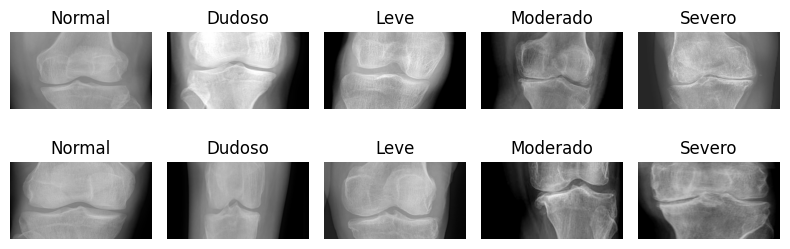

In [41]:
fig, axes = plt.subplots(2, len(categorias), figsize = (8, 3))

for i, categoria in enumerate(categorias):
    img_path = os.path.join(data_path, categoria)
    img = plt.imread(os.path.join(img_path, os.listdir(img_path)[0])) # Seleccionamos la primera imagen de cada categoria
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(nombres_categorias[i])
    
    img = plt.imread(os.path.join(img_path, os.listdir(img_path)[1]))
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title(nombres_categorias[i])

plt.tight_layout()
plt.show()

En la imagen, se presentan las primeras muestras de cada categoría de KOA. Se puede observar a simple vista que las imagenes tienen dimensiones iguales, sin importar la clase a la que pertenezcan.

## **Cantidad de imagenes**

Ahora veamos la cantidad de imágenes que tenemos en cada clase.

In [8]:
conteo_imagenes = {}
total_imagenes = 0

# Contar imágenes en cada categoría
for i in categorias:
    ruta_categoria = os.path.join(data_path, i)
    imagenes = glob(os.path.join(ruta_categoria, "*.png"))  # Obtener todas las imágenes
    conteo_imagenes[i] = len(imagenes)
    total_imagenes += conteo_imagenes[i]
    
for categoria, cantidad in conteo_imagenes.items():
    print(f"La cantidad de imágenes en la categoría {categoria.capitalize()} es de {cantidad} imágenes")

print(f"\nTotal de imágenes: {total_imagenes}")

La cantidad de imágenes en la categoría Normal es de 514 imágenes
La cantidad de imágenes en la categoría Doubtful es de 477 imágenes
La cantidad de imágenes en la categoría Mild es de 232 imágenes
La cantidad de imágenes en la categoría Moderate es de 221 imágenes
La cantidad de imágenes en la categoría Severe es de 206 imágenes

Total de imágenes: 1650


En este proceso, contamos con un total de 1650 imágenes, distribuidas de la siguiente manera: 514 corresponden a la categoría Normal, 477 a dudoso, 232 a leve, 221 a moderado y 206 a severo o grave. Se observa un desbalanceo claro en cada categoría que se manejará más adelante.

## **Organización de imágenes en un DataFrame**

Ahora vamos a almacenar las imágenes en un DataFrame con el objetivo de facilitar su análisis y procesamiento. Cada imagen será representada en su formato de píxeles y convertida a escala RGB para asegurar coherencia en la manipulación de datos. El DataFrame permitirá realizar transformaciones, exploraciones y futuras aplicaciones en modelos de análisis de imágenes.

In [ ]:
# Función para extraer números de los nombres de archivo y ordenarlos correctamente
def extraer_numero(nombre_archivo):
    coincidencia = re.search(r'\d+', nombre_archivo)
    return int(coincidencia.group()) if coincidencia else float('inf')

# Lista para almacenar la información de las imágenes
datos_imagenes = []

for categoria in categorias:
    ruta_categoria = os.path.join(data_path, categoria)  # Obtener la ruta completa de la categoría
    archivos_imagenes = glob(os.path.join(ruta_categoria, "*.png"))  # Obtener todas las imágenes en la carpeta

    # Ordenar las imágenes por el número extraído de su nombre
    archivos_imagenes = sorted(archivos_imagenes, key=extraer_numero)

    for ruta_imagen in archivos_imagenes:
        # Cargar la imagen original en formato BGR y convertirla a RGB
        imagen = cv2.imread(ruta_imagen)
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

        # Obtener las dimensiones de la imagen
        dimensiones = imagen.shape[:3]

        # Almacenar la información en la lista
        datos_imagenes.append({
            'Imagen': imagen,
            'Dimensiones': dimensiones,
            'Etiqueta': categoria  
        })

# Crear el DataFrame
df = pd.DataFrame(datos_imagenes)

# Mostrar el DataFrame
df

,Imagen,Dimensiones,Etiqueta
0,"[[[115, 115, 115], [115, 115, 115], [115, 115,...","(162, 300, 3)",Normal
1,"[[[22, 22, 22], [25, 25, 25], [27, 27, 27], [3...","(162, 300, 3)",Normal
2,"[[[7, 7, 7], [7, 7, 7], [8, 8, 8], [9, 9, 9], ...","(162, 300, 3)",Normal
3,"[[[74, 74, 74], [77, 77, 77], [79, 79, 79], [8...","(162, 300, 3)",Normal
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(162, 300, 3)",Normal
...,...,...,...
1645,"[[[63, 63, 63], [63, 63, 63], [63, 63, 63], [6...","(162, 300, 3)",Severe
1646,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(162, 300, 3)",Severe
1647,"[[[1, 1, 1], [3, 3, 3], [2, 2, 2], [0, 0, 0], ...","(162, 300, 3)",Severe
1648,"[[[63, 63, 63], [62, 62, 62], [63, 63, 63], [6...","(162, 300, 3)",Severe


Nótese que ahora se encuentran las imágenes almacenadas en una estructura más comóda. Como datos relevantes, nótese también que todas las imágenes cuentan con 3 canales de color (RGB)

In [9]:
df.shape

(1650, 3)

El conjunto de datos cuenta con 1650 observaciones, organizadas en 3 filas.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Imagen       1650 non-null   object
 1   Dimensiones  1650 non-null   object
 2   Etiqueta     1650 non-null   object
dtypes: object(3)
memory usage: 38.8+ KB


Se observa como no se presentan valores nulos o faltantes al llevar las iamgenes a un dataframe.

In [11]:
df['Dimensiones'].value_counts()

Dimensiones
(162, 300, 3)    1464
(161, 640, 3)     186
Name: count, dtype: int64

Se tienen 1464 imagenes de dimension 162x300 pixeles y las 186 imagenes restantes presentan 161x640 pixeles. Luego definimos la función mostrar imagen, donde se puede observar visualmente como la imagen fue guardada en el dataframe.

In [22]:
def mostrar_imagen(fila):
    # Extraer la imagen y las máscaras
    imagen = fila["Imagen"]  # Imagen original
    
    imagenes = [imagen]
    titulos = [f'Imagen original - {fila["Etiqueta"]}']

    # Crear la figura con subplots dinámicos
    fig, axes = plt.subplots(1, len(imagenes), figsize = (5 * len(imagenes), 5))

    # Si solo hay una imagen, hacer que 'axes' sea iterable
    if len(imagenes) == 1:
        axes = [axes]

    # Mostrar cada imagen
    for ax, img, title in zip(axes, imagenes, titulos):
        ax.imshow(img if img is not None else [[0]], None)
        ax.set_title(title)
        ax.axis("off")
    
    plt.show()

## **Análisis descriptivo de imágenes**

En esta sección veremos un poco más sobre cómo están distribuidas las clases, los píxeles y colores del conjunto de imágenes.

### **Distribución de clases**

Inicialmente, veamos la distribución de las clases de nuestro conjunto de datos.

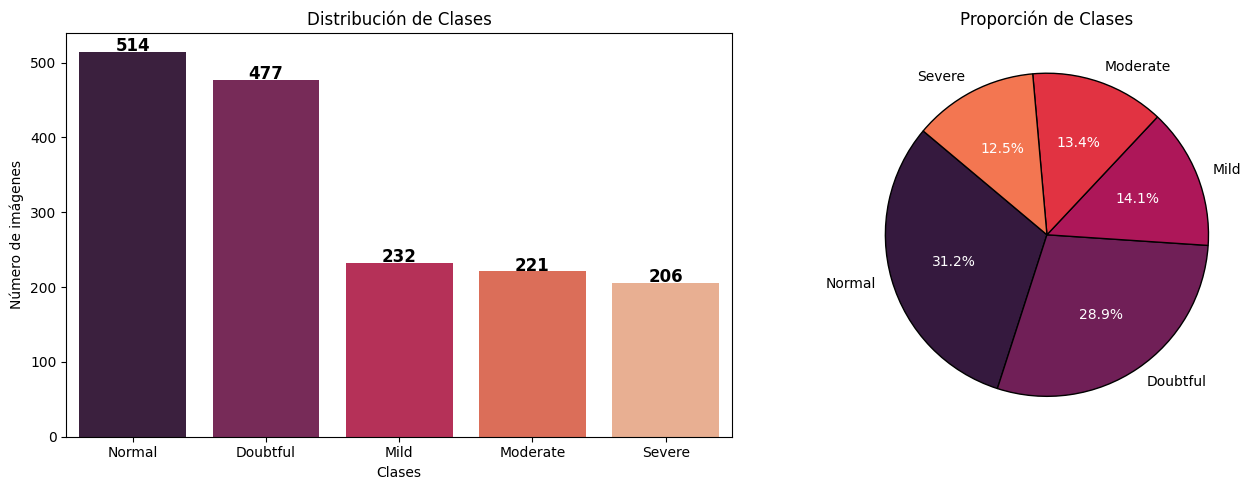

In [14]:
class_counts = df["Etiqueta"].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  

ax = sns.barplot(x = class_counts.index, y = class_counts.values, palette = "rocket", ax = axes[0])

# Agregar valores en las barras
for i, value in enumerate(class_counts.values):
    ax.text(i, value + 1, str(value), ha='center', fontsize = 12, fontweight = 'bold')

axes[0].set_xlabel("Clases")
axes[0].set_ylabel("Número de imágenes")
axes[0].set_title("Distribución de Clases")

axes[1].pie(class_counts, labels = class_counts.index, autopct = '%1.1f%%', colors = sns.color_palette("rocket"), startangle = 140, wedgeprops={'edgecolor': 'black'})
axes[1].set_title("Proporción de Clases")
for text in axes[1].texts:
    if '%' in text.get_text():  # Si es un porcentaje (valor dentro del gráfico)
        text.set_color('white')  
plt.tight_layout()
plt.show()

Al observar los gráficos, se puede decir que hay un desbalance en las clases, ya que las categorías Normal y Dudosa representan la mayoría de las imágenes (60.1%), mientras que las tres clases restantes tienen proporciones similares con 14.1% para Leve, 13.4% para Moderado y12.5% para Severo.
Esto se refleja en el gráfico de barras, donde las clases Normal y Dudosa tienen más del doble de observaciones comparado con las tres clases restantes. Además en el gráfico de pastel, se nota una disparidad clara en la distribución de los datos. Este desbalance puede afectar el renidmiento del modelo de clasificación, ya que puede ser vulnerable a sesgos hacia las clases mayoritarias, disminuyendo la detección de las clases minoritarias.

### **Distribución del tamaño de imágenes**

A continuación, analizaremos la distribución del tamaño de las imágenes en nuestro conjunto de datos, considerando la cantidad total de píxeles de cada imagen según su respectiva clase (*Normal, Dudoso, Leve, Moderado, Severo*). Este análisis es fundamental para comprender si existe variabilidad en el tamaño de las imágenes entre clases, lo que podría influir en el procesamiento y el desempeño de modelos. Para ello, utilizaremos un diagrama de caja (boxplot), que nos permitirá visualizar la dispersión, posibles valores atípicos y la tendencia general del tamaño de las imágenes en cada categoría.

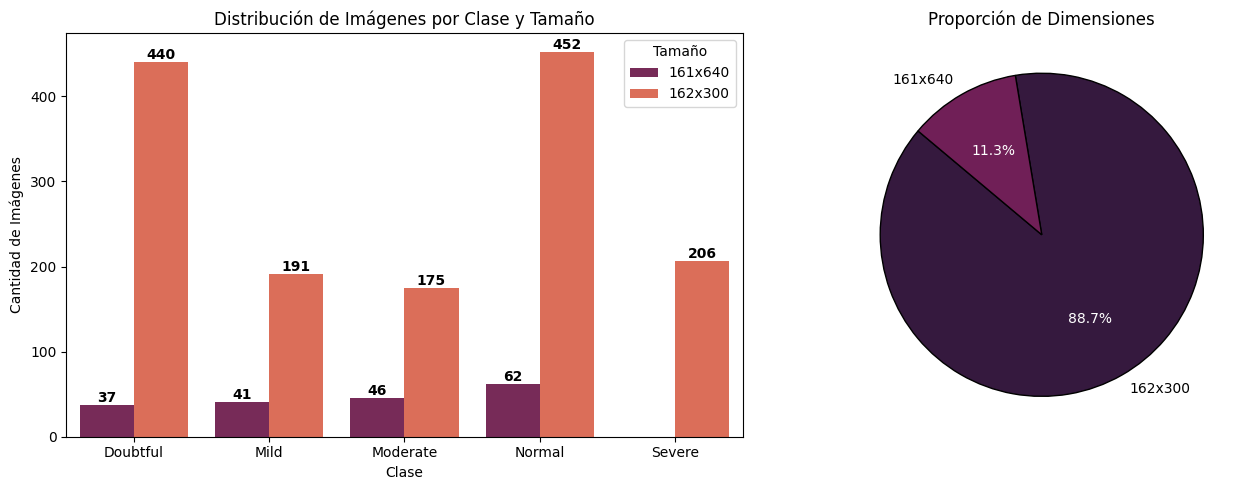

In [26]:
# Crear una nueva columna para clasificar las imágenes según su tamaño
df['Tamaño'] = df['Dimensiones'].apply(lambda x: f"{x[0]}x{x[1]}")
dimensiones_counts = df['Tamaño'].value_counts()

# Contar las imágenes por clase y tamaño
conteo_tamanos = df.groupby(['Etiqueta', 'Tamaño']).size().reset_index(name='Cantidad')

# Crear el gráfico de barras apiladas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax = sns.barplot(data=conteo_tamanos, x='Etiqueta', y='Cantidad', hue='Tamaño', palette='rocket', ax = axes[0])

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize = 10, fontweight = 'bold')

axes[0].set_title("Distribución de Imágenes por Clase y Tamaño")
axes[0].set_xlabel("Clase")
axes[0].set_ylabel("Cantidad de Imágenes")

axes[0].legend(title="Tamaño")


axes[1].pie(dimensiones_counts, labels = dimensiones_counts.index, autopct = '%1.1f%%', colors = sns.color_palette("rocket"), startangle = 140, wedgeprops={'edgecolor': 'black'})
axes[1].set_title("Proporción de Dimensiones")
for text in axes[1].texts:
    if '%' in text.get_text():  # Si es un porcentaje (valor dentro del gráfico)
        text.set_color('white')  

plt.tight_layout()
plt.show()

Las gráficas presentan un análisis detallado de la distribución de imágenes por categoría y tamaño. En la gráfica de barras, se observa las dimensiones por categoría, se puede ver como la clase Severo no tiene imágenes de tamaño 161x640, y las demás clases presentan pocas imágenes de esa dimensión comparado a las de 162x300. La gráfica de pastel revela que el 88.7% de las imágenes tienen dimensiones de 162x300, mientras que solo el 11.3% son de 161x640, destacando una clara preferencia por el tamaño más común. Esta variabilidad en los tamaños sugiere la necesidad de un preprocesamiento adecuado para garantizar la homogeneidad en la entrada de datos antes de aplicar modelos. Como se visualiza a continuación las imágenes de dimensión 161x640 son radiografías de las dos rodillas, y las de 162x300 contienen una sola rodilla.

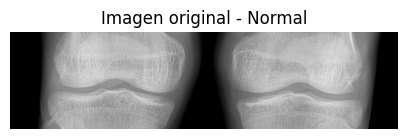

In [16]:
dos_rodillas = df[df['Tamaño'] == '161x640']
mostrar_imagen(dos_rodillas.iloc[0])

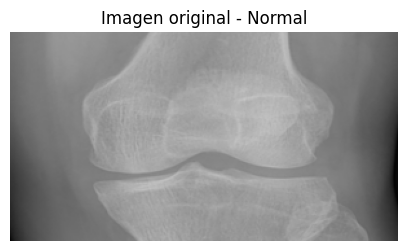

In [17]:
una_rodilla = df[df['Tamaño'] == '162x300']
mostrar_imagen(una_rodilla.iloc[0])

### **Mapa de intensidad de pixeles**

Para comprender mejor la distribución de los valores de los píxeles en nuestras imágenes, visualizaremos un mapa de intensidad. Este tipo de gráfico nos permite identificar patrones en la luminosidad y contraste, resaltando áreas de mayor y menor intensidad en una imagen. Convertiremos la imagen a escala de grises si es necesario y aplicaremos un heatmap para representar la variación en los niveles de intensidad de los píxeles. Esto es útil para detectar características relevantes en el procesamiento y análisis de imágenes.

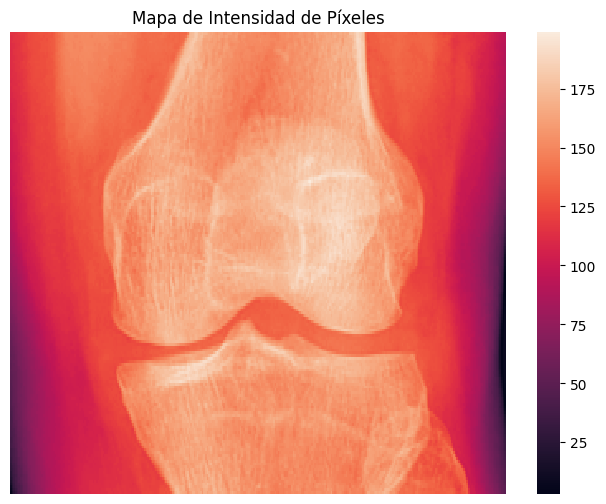

In [7]:
# Seleccionar una imagen del DataFrame
imagen = df["Imagen"].iloc[0]  # Tomamos la primera imagen como ejemplo

# Si la imagen es en color (RGB), la convertimos a escala de grises
if imagen.ndim == 3 and imagen.shape[-1] == 3:  # Vetificar si la imagen es a color
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)  # Conversión a escala de grises
else:
    imagen_gris = imagen  # Si ya está en escala de grises, se mantiene igual

# Graficar el heatmap para visualizar la intensidad de los píxeles
plt.figure(figsize=(8, 6))  # Definir tamaño de la figura
sns.heatmap(imagen_gris, cmap="rocket", cbar=True)  # Crear heatmap con la escala de colores "rocket"
plt.title("Mapa de Intensidad de Píxeles")  # Agregar título al gráfico
plt.axis("off")  # Ocultar los ejes para una mejor visualización
plt.show()  

La imagen nos muestra el **mapa de intensidad de píxeles** de la primera imagen del conjunto de datos, la cual corresponde a la clase **normal**. Se representa en escala de colores, donde los tonos más oscuros indican áreas de menor intensidad y los más claros corresponden a regiones de mayor intensidad. Este análisis es útil para identificar patrones visuales que ayuden en la evaluación y diagnóstico de imágenes médicas.

### **Histograma de escala de grises**

Exploremos cómo se representa la distribución de intensidades en una imagen en escala de grises a través de un histograma. Este gráfico nos permite visualizar la frecuencia de los diferentes niveles de brillo, lo que ayuda a analizar el contraste y la calidad de la imagen.

In [19]:
imagen = df.iloc[0]["Imagen"]

In [20]:
def mostrar_imagen_histograma(image):
    # Convertir la imagen de BGR a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calcular el histograma de la imagen en escala de grises
    gray_histogram = cv2.calcHist([gray_image], [0], None, [256], [0, 256])

    # Crear una figura con dos subgráficos: uno para la imagen y otro para el histograma
    fig, axs = plt.subplots(1, 2, figsize=(12,6))

    # Mostrar la imagen original en el primer subgráfico (convertida a RGB para visualizarla correctamente)
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Imagen Original', fontsize=14)
    axs[0].axis('off')  # Ocultar ejes para una mejor visualización

    # Graficar el histograma en el segundo subgráfico
    axs[1].plot(gray_histogram, color='gray')
    axs[1].set_title('Histograma de Escala de Grises', fontsize=14)
    axs[1].set_xlabel('Valor de Píxel', fontsize=14)
    axs[1].set_ylabel('Frecuencia', fontsize=14)

    plt.tight_layout()
    plt.show()

Veamos esto para la primera imagen

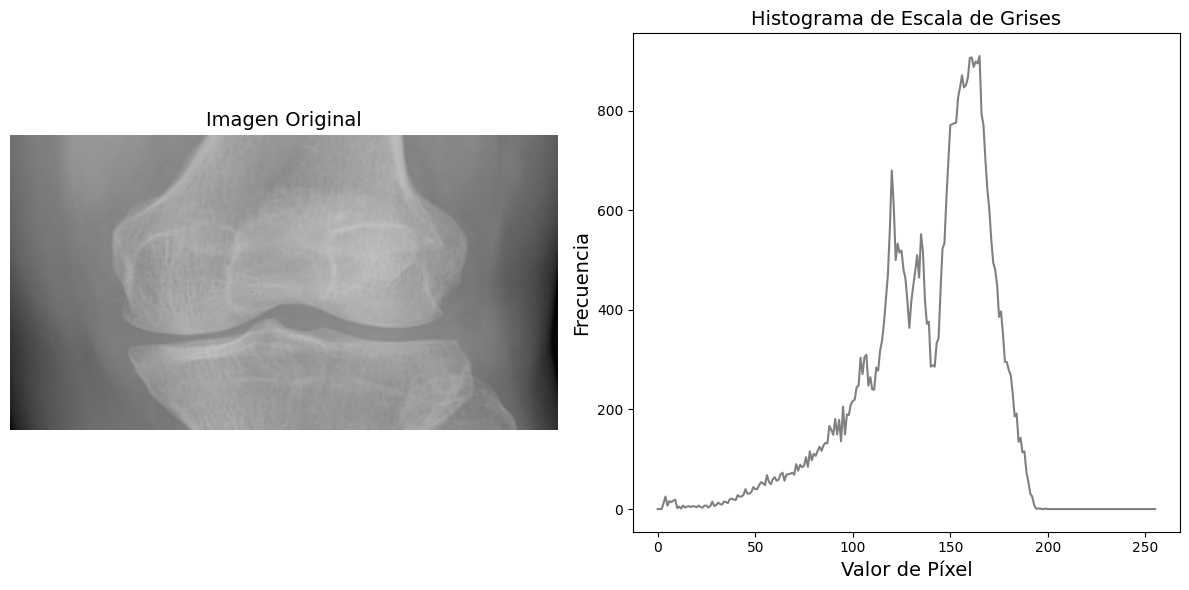

In [21]:
mostrar_imagen_histograma(imagen)

En la imagen original, se observa como el área más iluminada corresponde a los huesos de la rodilla que se están analizando, las áreas más grises corresponden a la parte de la pierna que no contiene a los huesos, en cambio la parte oscura es donde no hay nada a analizar.

El histograma a la derecha ilustra la distribución de los valores de píxeles en la imagen en la escala de grises. Se observa que hay mayor concentración de píxeles en los rangos de intensidad media (valores entre aproximadamente 100 y 200), lo que indica una predominancia de tonos oscuros y grises. Además se pueden notar picos en los niveles de intensidad alrededor de 120 y 170, que corresponden a los valroes más representativos en la imagen.

### **Distrución de intesidad de píxeles**

En esta sección, analizaremos la distribución de la intensidad de píxeles en las imágenes de cada clase **Normal(Sin enfermedad), Dudoso, Leve, Moderada y Severa.**. Esto nos permitirá identificar patrones y diferencias en los valores de brillo y contraste entre las categorías. Para ello, generaremos histogramas que muestran la frecuencia de los niveles de intensidad (0-255) en cada clase, utilizando distintos colores para diferenciarlas. Además, incorporaremos una curva de densidad para visualizar mejor la distribución y compararlas entre sí. Este análisis es clave para entender cómo varían las características visuales en las imágenes y cómo pueden influir en modelos de clasificación.

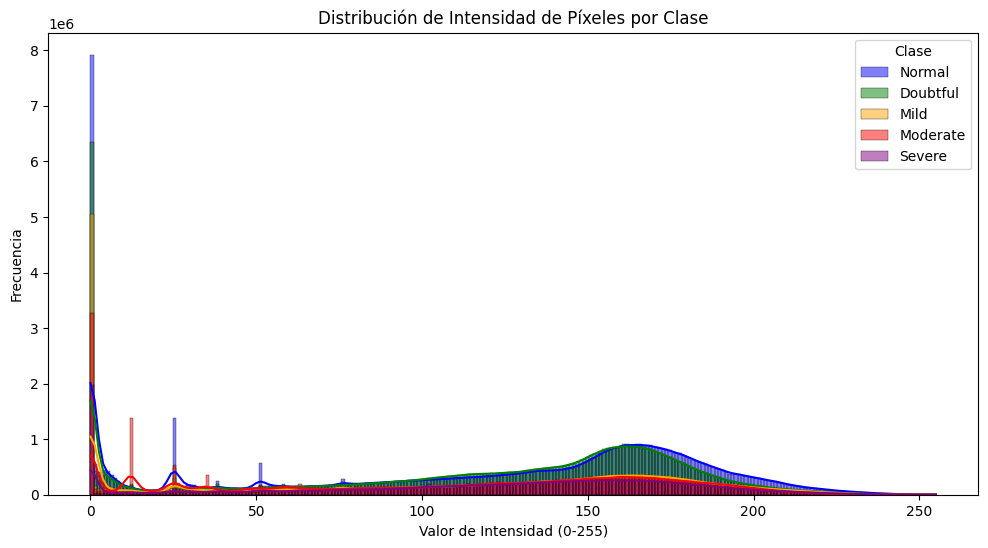

In [7]:
plt.figure(figsize=(12, 6))

# Definir un diccionario con los colores correspondientes a cada clase
colores = {"Normal": "blue", "Doubtful": "green", "Mild": "orange", "Moderate": "red", "Severe": "purple"}

# Recorrer cada clase de imágenes en el DataFrame
for clase in df["Etiqueta"].unique():
    
    # Extraer todas las imágenes de la clase actual, aplanarlas y concatenarlas en un solo array
    pixeles = np.concatenate(
        df[df["Etiqueta"] == clase]["Imagen"].apply(lambda img: img.flatten()).values
    )
    
    # Graficar el histograma de la intensidad de píxeles para la clase actual
    sns.histplot(
        pixeles,        # Datos de píxeles de la clase actual
        bins=256,       # Se establecen 256 bins para representar cada nivel de intensidad (0-255)
        kde=True,       # Se añade una curva de densidad (Kernel Density Estimation) para visualizar la distribución
        color=colores[clase],  # Se asigna un color según la clase
        label=clase,    # Se etiqueta el histograma con el nombre de la clase
        alpha=0.5       # Se establece una transparencia del 50% para permitir la superposición de histogramas
    )

plt.title("Distribución de Intensidad de Píxeles por Clase")  
plt.xlabel("Valor de Intensidad (0-255)")  
plt.ylabel("Frecuencia")  
plt.legend(title="Clase")
plt.show()

El gráfico muestra la distribución de la intensidad de píxeles para las imágenes de cada clase (Normal, Doubtful, Mild, Moderate, Severe). Se observa que la mayoría de los píxeles tienen valores de intensidad bajos (cercanos a 0), lo que indica una predominancia de tonos oscuros en las imágenes.

La clase Normal (azul) tiene una mayor cantidad de píxeles en todos los niveles de intensidad en comparación con las otras clases, lo que sugiere que estas imágenes pueden contener más variabilidad en el contraste. Las clases Doubtful (verde), Mild (amarillo), Moderate (rojo) y Severe (morado) presentan distribuciones más específicas, con picos en diferentes niveles de intensidad.

### **Filtrado de imágenes con OpenCV**

A continuación se hará un filtrado de imágenes.

Los filtros en imágenes son operaciones matemáticas aplicadas sobre los píxeles para modificar ciertas características visuales, se pueden usar para mejorar contraste, eliminar ruido o detectar bordes. En este caso, se emplean filtros de suavizado para reducir el ruido presente en la imagen original.

El filtrado de imágenes es un proceso fundamental en la visión por computadora, ya que permite mejorar la calidad de las imágenes eliminando ruido, resaltando características importantes y suavizando detalles no deseados.

**Tipos de filtros aplicados**

* **Filtro de Media (cv2.blur):** Calcula el promedio de los valores de píxeles en una vecindad definida por una ventana (en este caso, de 3x3). Suaviza la imagen pero puede afectar los bordes.

* **Filtro de Mediana (cv2.medianBlur):** Sustituye el valor de cada píxel por la mediana de los valores en su vecindad. Es especialmente útil para eliminar ruido impulsivo o “ruido sal y pimienta” (píxeles blancos (sal) y píxeles negros (pimienta))

* **Filtro Gaussiano (cv2.GaussianBlur):** Aplica un suavizado utilizando una función gaussiana, lo que genera un efecto más natural y mantiene mejor los bordes en comparación con el filtro de media.

In [16]:
def aplicar_filtros_y_visualizar(imagen):
    # Aplicación de filtros
    meanimg = cv2.blur(imagen, (3, 3))  # Filtro de media
    medianimg = cv2.medianBlur(imagen, 3)  # Filtro de mediana
    gaussianimg = cv2.GaussianBlur(imagen, (3, 3), 0)  # Filtro gaussiano

    # Creación de la figura con subgráficos 2x2
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Imagen Original con Ruido
    axs[0, 0].imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title('Imagen con Ruido', fontsize=14)
    axs[0, 0].axis('off')

    # Filtro Media
    axs[0, 1].imshow(cv2.cvtColor(meanimg, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title('Filtro Media', fontsize=14)
    axs[0, 1].axis('off')

    # Filtro Mediana
    axs[1, 0].imshow(cv2.cvtColor(medianimg, cv2.COLOR_BGR2RGB))
    axs[1, 0].set_title('Filtro Mediana', fontsize=14)
    axs[1, 0].axis('off')

    # Filtro Gaussiano
    axs[1, 1].imshow(cv2.cvtColor(gaussianimg, cv2.COLOR_BGR2RGB))
    axs[1, 1].set_title('Filtro Gaussiano', fontsize=14)
    axs[1, 1].axis('off')

    # Ajustar diseño y mostrar
    plt.tight_layout()
    plt.show()

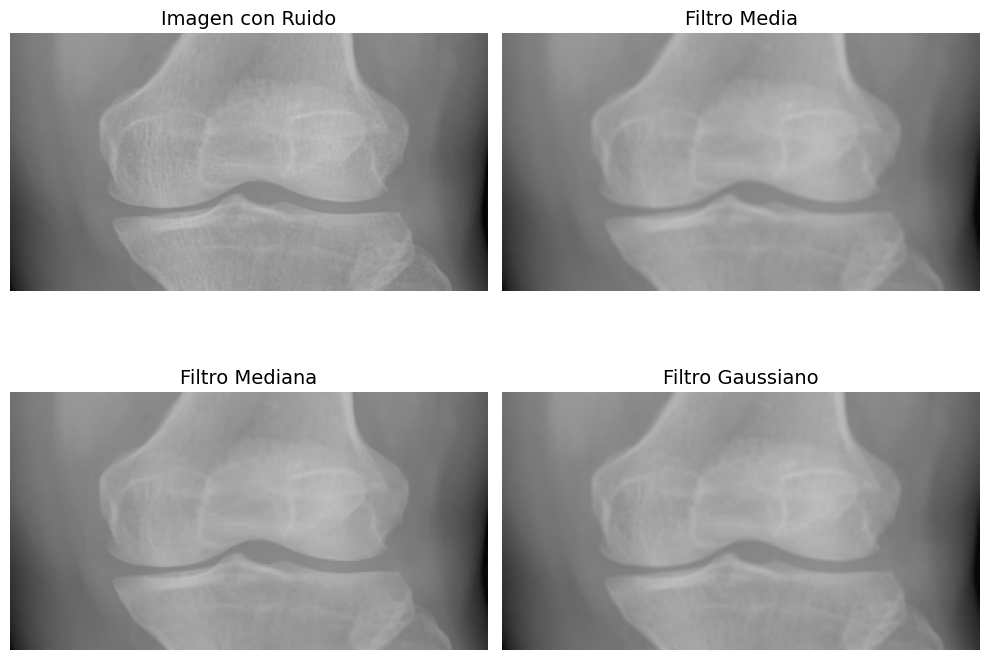

In [17]:
aplicar_filtros_y_visualizar(imagen)

La imagen muestra una comparación del efecto de diferentes filtros de suavizado aplicados a una imagen radiográfica de la rodilla. En la esquina superior izquierda se observa la imagen original con ruido, que puede dificultar la interpretación médica al introducir artefactos visuales. En la parte superior derecha, el filtro de media ha suavizado la imagen promediando los valores de los píxeles vecinos, reduciendo el ruido pero también perdiendo algunos detalles. En la parte inferior izquierda, el filtro de mediana ha preservado mejor los bordes y estructuras relevantes, eliminando especialmente el ruido tipo sal y pimienta. Finalmente, en la esquina inferior derecha, el filtro gaussiano ha suavizado la imagen de manera más natural, manteniendo un balance entre reducción de ruido y preservación de detalles.

Otro tipo de filtrado es el usado para la detección de bordes, que en este contexto es importante para visualizar que tan cerca se presentan los huesos, tomaremos como referencia el siguiente filtro:

* **Filtro de Sobel (cv2.Sobel):** Detecta bordes en direcciones específicas (horizontal o vertical). Se aplica en derivadas de primer orden en X e Y.

Así, se visualizará una imagen con el filtro de sobel para cada eje y una versión combinada que consiste en calcular la magnitud del gradiente combinado entre los filtors para x y para y

In [18]:
def aplicar_filtros_de_bordes_y_visualizar(imagen):
    # Aplicación de filtros
    sobelx = cv2.Sobel(imagen, cv2.CV_64F, 1, 0, ksize=3)  # Bordes en X
    sobely = cv2.Sobel(imagen, cv2.CV_64F, 0, 1, ksize=3)  # Bordes en Y

    # Calcular la magnitud del gradiente combinando sobelx y sobely
    sobel_combinado = cv2.magnitude(sobelx, sobely)

    # Normalizar la imagen para mostrarla correctamente
    sobel_combinado = np.uint8(sobel_combinado)

    # Normalizar y convertir a uint8
    sobelx = cv2.normalize(sobelx, None, 0, 255, cv2.NORM_MINMAX)
    sobelx = np.uint8(sobelx)

    sobely = cv2.normalize(sobely, None, 0, 255, cv2.NORM_MINMAX)
    sobely = np.uint8(sobely)

    # Creación de la figura con subgráficos 2x2
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))

    # Imagen Original con Ruido
    axs[0, 0].imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title('Imagen con Ruido', fontsize=14)
    axs[0, 0].axis('off')

    # Filtro Media
    axs[0, 1].imshow(cv2.cvtColor(sobelx, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title('Filtro Sobel para eje x', fontsize=14)
    axs[0, 1].axis('off')

    # Filtro Mediana
    axs[1, 0].imshow(cv2.cvtColor(sobely, cv2.COLOR_BGR2RGB))
    axs[1, 0].set_title('Filtro Sobel para eje y', fontsize=14)
    axs[1, 0].axis('off')

    # Filtro Gaussiano
    axs[1, 1].imshow(cv2.cvtColor(sobel_combinado, cv2.COLOR_BGR2RGB))
    axs[1, 1].set_title('Filtro sobel combinado', fontsize=14)
    axs[1, 1].axis('off')

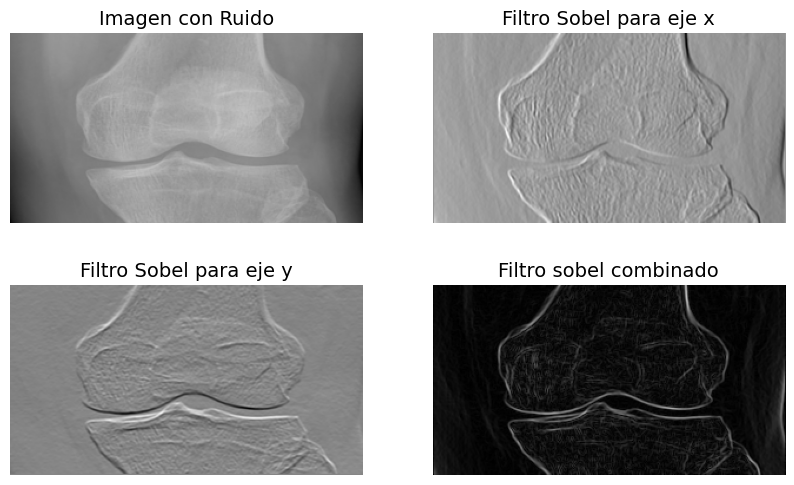

In [19]:
aplicar_filtros_de_bordes_y_visualizar(imagen)

En la imagen se observa una comparación del efecto del filtro de detección de bordes Sobel aplicado a una imagen de rodilla. Para el filtro sobre el eje x, se notan mas los bordes verticales en la imagen; en cambio, para el eje y se resaltan los bordes horizontales como por ejemplo los contornos de la separación que se presenta en los huesos. Por último, el filtro combinado oscurece por completo la imagen con ruido y resalta todos los bordes de los huesos, por lo que se hace más fácil para visualizar y detectar los tipos de artritis.

## **Pre - procesamiento**

### **Redimensión de imágenes**

Redimensionar las imágenes es fundamental en el procesamiento de datos, ya que garantiza que todas tengan un tamaño uniforme, reduce el costo computacional y facilita su uso en modelos de Deep Learning. Al ajustar las dimensiones, se evita el problema de trabajar con imágenes de diferentes tamaños, lo que mejora la eficiencia y compatibilidad. Además, redimensionarlas ayuda a optimizar el uso de memoria y acelera el entrenamiento sin afectar significativamente la calidad visual.

In [20]:
target_size = (256, 256)
# Redimensionar todas las imágenes
df["Imagen"] = df["Imagen"].apply(lambda img: cv2.resize(img, target_size))

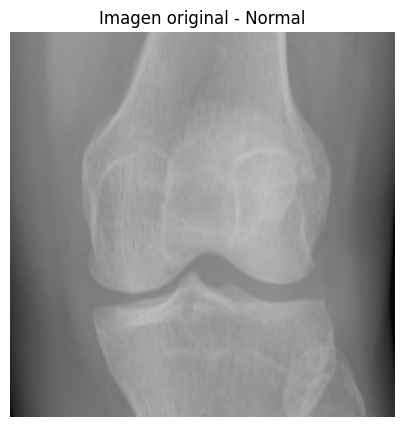

In [23]:
mostrar_imagen(df.iloc[0])

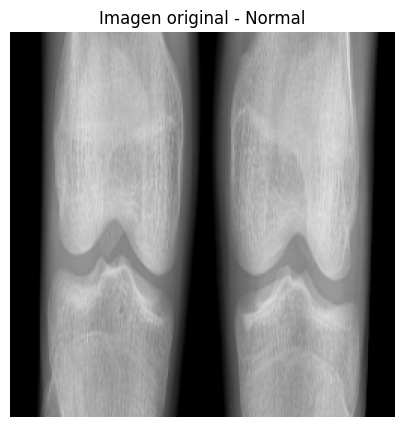

In [27]:
dos_rodillas = df[df['Tamaño'] == '161x640']
mostrar_imagen(dos_rodillas.iloc[0])

Al inicio de este análisis exploratorio, observamos que varias imágenes de diferentes clases presentaban variaciones en tamaño. Ahora, tras un proceso de preprocesamiento, todas las imágenes han sido normalizadas a un tamaño uniforme, lo que facilita su comparación y análisis.

### **Escalado de pixeles**

En esta sección, escalaremos los valores de los píxeles de nuestras imágenes para estandarizar su rango y mejorar el rendimiento de los modelos de aprendizaje automático. La normalización de los píxeles es crucial, ya que muchos algoritmos de visión por computadora funcionan mejor cuando los valores están en un rango uniforme, como [0,1] o [-1,1]. Antes de realizar este escalado, primero verificamos que los valores de los píxeles de la imagen original y su máscara efectivamente se encuentran en el rango de 0 a 255. Para ello, calculamos métricas estadísticas como el valor mínimo, el máximo, la media y la desviación estándar, lo que nos permite asegurarnos de que la escala de los datos es la esperada antes de aplicar cualquier transformación.

In [28]:
print("Mínimo:", np.min(imagen))
print("Máximo:", np.max(imagen))
print("Media:", np.mean(imagen))
print("Desviación estándar:", np.std(imagen))

Mínimo: 3
Máximo: 199
Media: 138.18343621399177
Desviación estándar: 31.74691186373553


Vemos que para la primera imagen del conjunto de datos el mínimo de píxeles es 31 y el máximo es 199.

In [31]:
# Normalización de las imágenes dividiendo por 255 para que los valores estén en el rango [0,1]
df["Imagen"] = df["Imagen"].apply(lambda x: x.astype(np.float32) / 255.0)

In [32]:
# Eliminar columnas innecesarias para el análisis posterior
df.drop(columns=["Dimensiones", "Tamaño"], inplace=True)
df.to_pickle("imagenes_normalizadas.pkl")

In [33]:
df.head()

,Imagen,Etiqueta
0,"[[[0.4509804, 0.4509804, 0.4509804], [0.450980...",Normal
1,"[[[0.08627451, 0.08627451, 0.08627451], [0.098...",Normal
2,"[[[0.02745098, 0.02745098, 0.02745098], [0.027...",Normal
3,"[[[0.2901961, 0.2901961, 0.2901961], [0.301960...",Normal
4,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",Normal


Luego de escalar los píxeles obtenemos lo siguiente.

In [34]:
print("Mínimo:", np.min(df["Imagen"].iloc[0] ))
print("Máximo:", np.max(df["Imagen"].iloc[0] ))
print("Media:", np.mean(df["Imagen"].iloc[0] ))
print("Desviación estándar:", np.std(df["Imagen"].iloc[0] ))

Mínimo: 0.015686275
Máximo: 0.7647059
Media: 0.5414152
Desviación estándar: 0.12432286


Vemos que para la primera imágen han cambiado las principales estadísticas y ahora se encuentran normalizadas.

Ahora veamos esto gráficamente solo para la primera imágen.

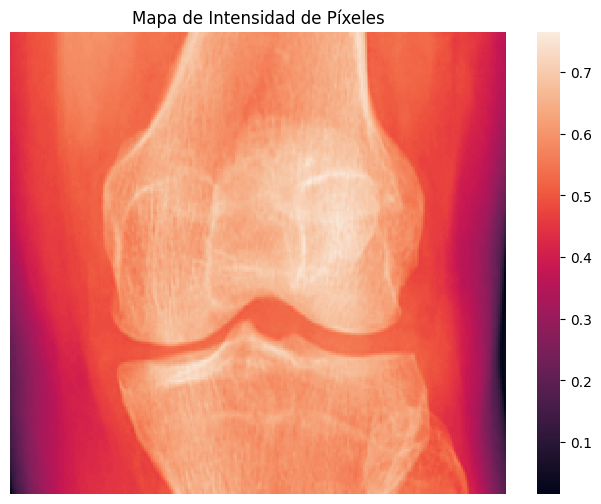

In [38]:
# Seleccionar una imagen del DataFrame
imagen_new = df["Imagen"].iloc[0]  # Tomamos la primera imagen como ejemplo

# Si la imagen es en color (RGB), la convertimos a escala de grises
if imagen.ndim == 3 and imagen.shape[-1] == 3:  # Vetificar si la imagen es a color
    imagen_gris = cv2.cvtColor(imagen_new, cv2.COLOR_RGB2GRAY)  # Conversión a escala de grises
else:
    imagen_gris = imagen_new  # Si ya está en escala de grises, se mantiene igual

# Graficar el heatmap para visualizar la intensidad de los píxeles
plt.figure(figsize=(8, 6))  # Definir tamaño de la figura
sns.heatmap(imagen_gris, cmap="rocket", cbar=True)  # Crear heatmap con la escala de colores "rocket"
plt.title("Mapa de Intensidad de Píxeles")  # Agregar título al gráfico
plt.axis("off")  # Ocultar los ejes para una mejor visualización
plt.show()  

Evidentemente, observamos que la escala del mapa de calor ha cambiado, pero la distribución y predominancia de los colores se han mantenido. Esto sugiere que el escalamiento se realizó correctamente, preservando la estructura de la información original sin alterar los patrones de intensidad en la imagen.